**Implementasi Metode Analisis Data Fungsional (FDA) untuk Visualisasi dan Analisis Data Operasional, Kinerja, dan Konsumsi Energi pada Komputer Paralel**

Pada penelitian kali ini, saya melakukan uji coba terhadap data operasional, kinerja dan konsumsi energi dari komputer yang mana datanya diambil menggunakan tools bernama Turbostat. Turbostat merupakan tools yang tersedia di komputer dengan processor intel(bisa dengan AMD, namun data yang diberikan hanya beberapa). Turbostat berfungsi untuk mengukur dan memantau berbagai parameter operasional dari prosesor, seperti frekuensi CPU, temperatur, konsumsi daya, dan informasi terkait power states pada sistem berbasis Intel. Tools ini memberikan data yang berguna dalam menganalisis kinerja dan efisiensi energi komputer dengan cara memonitor penggunaan daya pada tingkat perangkat keras. Tools ini digunakan karena memiliki keunggulan yaitu salah satu fitur utamanya adalah kemampuan untuk melakukan real-time monitoring, memungkinkan pengguna untuk memantau kinerja sistem secara langsung dan melakukan penyesuaian segera untuk mengidentifikasi gangguan kemudian mengoptimalkannya. 

Dalam penelitian ini, Turbostat digunakan untuk mengumpulkan data terkait operasional, kinerja dan konsumsi energi saat komputer menjalankan tugas tertentu. Data yang diperoleh kemudian dianalisis menggunakan metode FDA, dengan cara melakukan visualisasi MSPlot untuk menganalisis outlier dari data. Dengan melakukan analisis ini, diharapkan dapat menemukan anomali dari data yang mana direpresentasikan sebagai outlier di MSPlot. Anomali ini dalam konteks data kinerja komputer, dapat berarti adanya error atau malfungsi dari suatu perangkat keras atau komponen tertentu ataupun system embeddednya. 

Ada 2 macam MSPlot yang digunakan dalam penelitan kali ini, yaitu yang pertama adalah MSPlot dari library scikit-FDA, dengan library ini kita dapat melakukan banyak macam analisis data fungsional seperti FPCA dan juga MSPlot. Kemudian MSPlot lainnya menggunakan Incremental and progressive FDA untuk menggenerate MSPlot. Ini berdasarkan algortima yang saya temui pada sebuah paper yang berjudul "A Visual Analytics Approach for Hardware System Monitoring with Streaming Functional Data Analysis". Dengan menggunakan 2 macam MSPlot ini, kita akan melihat antara keduanya mana yang lebih efektif dan akurat dalam menampilkan MSPlot untuk mendeteksi outlier dengan data.

Library yang dipakai

In [3]:
import re
import time
import json
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from skfda.exploratory.depth import IntegratedDepth
from skfda.exploratory.depth.multivariate import SimplicialDepth
from skfda.exploratory.visualization import MagnitudeShapePlot
from skfda import FDataGrid
from inc_ms_fda import IncFDO
from prog_ms_fda import ProgressiveFDA

Data yang dipakai untuk uji coba 
Data dibawah ini merupakan data yang sudah difilter(dengan hanya menambil baris pertama pada setiap iterasi saat turbostat berjalan, hal ini dikarenakan baris pertama merupakan summary dari data kumpulan core, maka dari itu pengambilan baris pertama akan cukup representatif)

In [4]:
dir = "/filtered_test2.csv"
data = pd.read_csv(dir)
df = data #failsafe

Normalisasi data (min, max scala -1,1)
Normalisasi data dilakukan karena adanya asumsi bahwa data dengan rentang atau satuan yang jauh, akan menyebabkan ketidakakuratan data(karena adanya asumsi akan banyak menimbulkan outlier)

In [5]:
def normalize(data, target_min=-1, target_max=1):
    # Menentukan nilai minimum dan maksimum dari data asli
    data_min = np.min(data)
    data_max = np.max(data)
    
    # Menghitung rentang target
    target_range = target_max - target_min
    
    # Normalisasi data
    normalized_data = (data - data_min) * target_range / (data_max - data_min) + target_min
    
    return normalized_data

Skenario
Dibawah ini saya melkukan beberapa skenario untuk percobaan pada penelitian kali ini. Skenario ini dibuat dengan asumsi bahwa, pada data kali ini, beberapa parameter memiliki rentang data yang berbeda, ada yang ribuan ada yang persen. Hal tersebut menimbulkan asumsi, apakah dengan hal itu dapat mempengaruhi MSPlot nantinya sehingga tidak akurat dalam menampilkan outlier? (yang mana seharusnya data tersebut bukan outlier, namun plot menjadi outlier dikarenakan rentang data yang berbeda)

In [6]:
# Saya melakukan pengelompokan dibawah ini berdasarkan pengataman terhadap kolom yang memiliki karakteristik kurva, jenis dan rentang data yang mirip
# 1 ['CPU%c3','CPU%c3','CPU%c6','CPU%c7','Pkg%pc2','Pkg%pc3','C1%','C1E%','C3%','C6%','C8%','C10%',]
# 2 ['C1', 'IRQ', 'POLL']
# 3 ['C1E', 'C3', 'C6', 'C8', 'C10']
# 4 ['PkgWatt', 'CorWatt', 'RAMWatt']
# 5 ['PkgTmp', 'CoreTmp']

kol_sken1 = ['C1', 'IRQ', 'POLL', 'C1E', 'C3', 'C6', 'C8', 'C10'] #skenario 1, penggabungan kelompok 2 dan 3

df_norm = df[kol_sken1]
df_norm = normalize(df_norm) # Normalisasi

core_data = df_norm.values.T

data_fda = FDataGrid(data_matrix=core_data) # Membuat data grid untuk melakukan MSPlot dengan library scikit-FDA

In [7]:
# Pada kode dibawah ini berfungsi untuk membuat variable untuk isi parameter dari library plot nya
core_names = df_norm.columns[0:]  
ncores = len(core_names)
core_names = core_names.values

core_names = np.arange(len(core_names))
print(core_names)

[0 1 2 3 4 5 6 7]


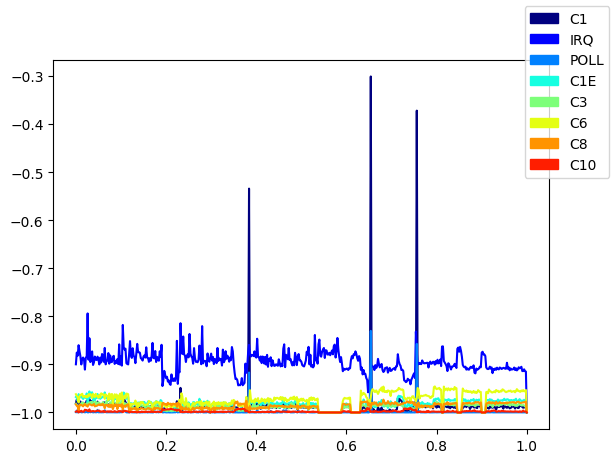

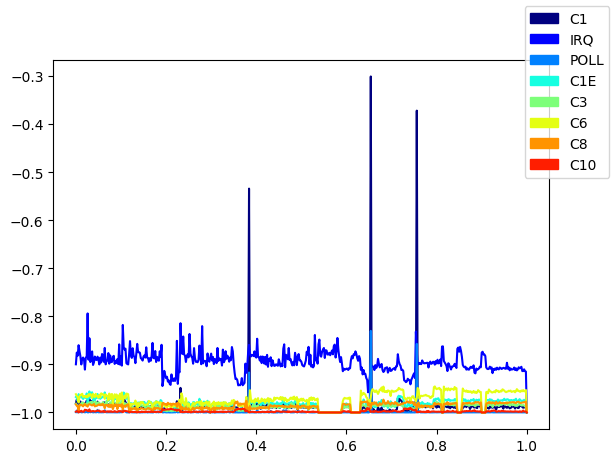

In [8]:
# Melakukan data Plot
colormap = plt.colormaps['jet']
label_names = df_norm.columns[0:]
nlabels = len(label_names)
label_colors = colormap(np.arange(nlabels) / (nlabels))

data_fda.plot(
    group=core_names,
    group_colors=label_colors,
    group_names=label_names,
)

*nb: data direperesntasikan kedalam bentuk kurva dengan warna berbeda.*

Melakukan MSPlot menggunakan tools/library scikit-FDA, menggunakan SimplicialDepth untuk plot MS yang sederhana

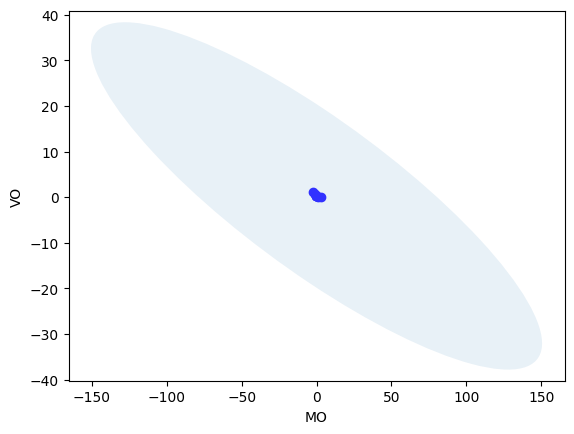

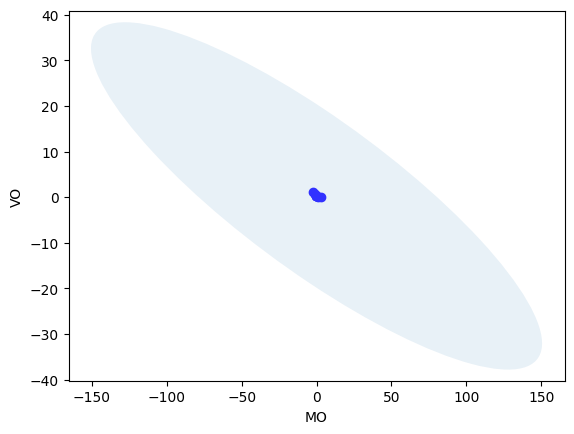

In [9]:
msplot = MagnitudeShapePlot(
    data_fda,
    multivariate_depth=SimplicialDepth(),
)

color = 0.3
outliercol = 0.7

msplot.color = color
msplot.outliercol = outliercol
msplot.plot()

*nb: dapat dilihat pada msplot ini, tidak terlalu memperlihatkan outlier.*

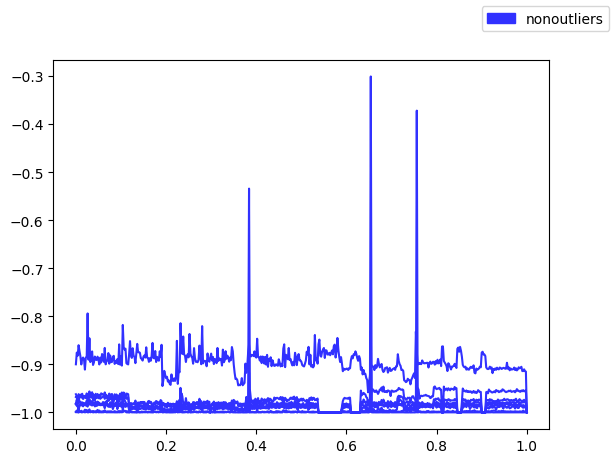

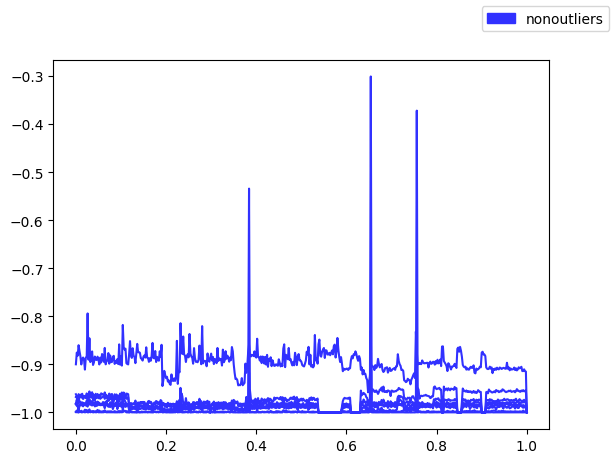

In [10]:
# Melakukan plot data berdasarkan hasil plot MS
data_fda.plot(
    group=msplot.outliers.astype(int),
    group_colors=msplot.colormap([color, outliercol]),
    group_names=['nonoutliers', 'outliers'],
)

*nb: pada plot ini, mengindikasikan tidak adanya outlier yang terdeteksi dengan menggunakan SimplicialDepth.*

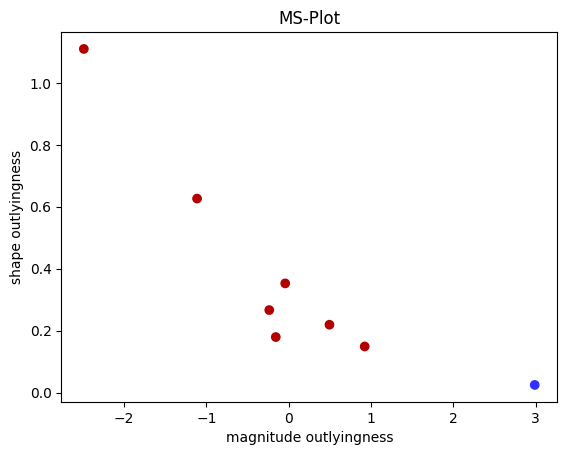

In [11]:
# Pada bagian ini, plot dilakukan scatter point dilakukan pengelompokan untuk lebih akurat dalam menampilkan outlier
colormap = plt.colormaps['seismic']
group1 = np.where(msplot.points[:, 0] < -0.6)
group2 = np.where(msplot.points[:, 1] > 0.12)

colors = np.copy(msplot.outliers).astype(float)
colors[:] = color
colors[group1] = outliercol
colors[group2] = 0.9

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(msplot.points[:, 0], msplot.points[:, 1], c=colormap(colors))
ax.set_title("MS-Plot")
ax.set_xlabel("magnitude outlyingness")
ax.set_ylabel("shape outlyingness")

labels = np.copy(msplot.outliers.astype(int))
labels[group1] = 1
labels[group2] = 2

*nb: pada msplot kali ini, mulai terlihat satu titik biru, yang mana berarti mengindikasikan data point tersebut merupakan outlier.*

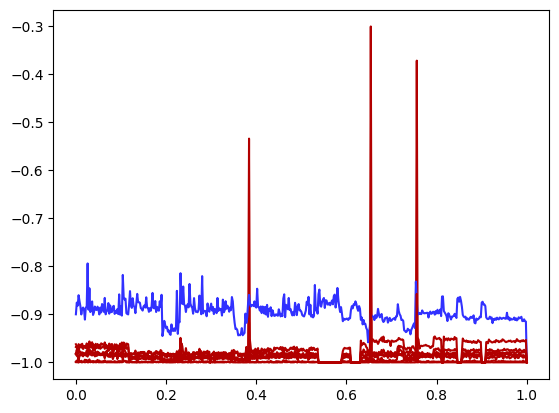

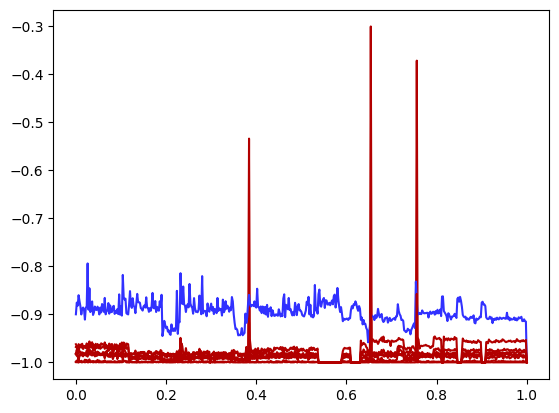

In [12]:
data_fda.plot(
    group=labels,
    group_colors=colormap([color, outliercol, 0.9]),
)

*nb: dari plot di atas, diketahui outlier merupakan kolom IRQ.*

Setelah melihat hasil plot MS menggunakan scikit-FDA, sekarang melakukan plot MS menggunakan Incremental and progerssive MSPlot. Dengan diintegrasikan menggunakan plot interaktif plotly

In [13]:
# Inisialisasi dan fitting data menggunakan IncFDO
cores = df_norm
X = cores.T.to_numpy()

inc_fdo = IncFDO()
inc_fdo.initial_fit(X)

# Mengonversi hasil ke DataFrame untuk visualisasi
plot_data = pd.DataFrame({
    'MO': inc_fdo.MO,
    'VO': inc_fdo.VO,
    'Label': label_names  # Menggunakan label sebagai kategori
})

# Membuat scatter plot menggunakan plotly express
fig = px.scatter(
    plot_data, 
    x='MO', 
    y='VO', 
    color='Label',  # Warna berdasarkan label unik
    title='MS Plot',
    labels={'MO': 'MO', 'VO': 'VO'},
    template='plotly'
)

# Menampilkan plot
fig.show()

*nb: pada msplot kali ini, menggunakan IncMSPlot, dengan sekali iterasi, dapat langsung terlihat MSPlot dengan adanya terlihat outlier yaitu masih sama seperti pada msplot sebelumnya, yaitu kolom IRQ. Dan pada plot ini juga lebih interaktif, yang mana kita bisa melakukan exlcude terhadap kolom yang tidak kita inginkan, sehingga kita bisa mengobservasi kolom tertentu yang memang secara proper observasinya(dibutuhkan ahli dalam bidanhnya)*

Melakukan simulasi untuk melakukan perbandingan antara MSPlot dengan IncMSPlot. Simulasi dilakukan menggunakan beberapa skenario yaitu dengan cara membuat beberapa sample set. Sample set dibuat dari yang kecil sampai besar, hal ini dilakukan untuk melihat keefektifan setiap metode, untuk menentukan mana yang lebih efektif dan bagus.

In [ ]:
result_dict = {"MS":[], "Inc-MS":[]}
ts = X
#creating larger sample set for analysis]
n = 20000
n1 = (n//df_norm.shape[0])+1
n2 = (n//df_norm.shape[1])+1
ts_ = np.hstack([ts for i in range(n1)])[:n,:n]
ts_new = np.vstack([ts_ for i in range(n2)])[:n,:n]
dataSize = [500, 1000, 2000, 5000, 10000, 19999]
for d_size in dataSize:#[20000, 40000,50000,60000]:

    n = d_size

    ts_m = ts_new[:n,:n]
    ts_prg = ts_new[:n-1,:n]
    ts_prg_add = ts_new[n-1,:n]
    print("ts_m shape",ts_m.shape)

    first = int(d_size *(5/100)) # 5% of the data for initial processing
    test_set_inc = ts_m[:,:first]

    #MagnitudeShapePlot
    start = time.process_time()
    inc_fdo1 = IncFDO()
    inc_fdo1.initial_fit(ts_m)
    end = time.process_time() - start
    result_dict["MS"].append(end)
    print("Overall MS for data size {} completed in {} ".format(d_size, end))


    #inc MagnitudeShapePlot
    start = time.process_time()
    inc_fdo = IncFDO()
    inc_fdo.initial_fit(test_set_inc) #using 5% of data for initial processing
    print("first,n", first,n)
    for i in range(first,n):
        inc_fdo.partial_fit(ts_m[:,i]) # adding the rest of the timepoints incrementally
    end = time.process_time() - start
    result_dict["Inc-MS"].append(end)
    print("Inc-MS for data size {} completed in {} ".format(d_size, end))
    
    #progressive MagnitudeShapePlot
    prg_fda = ProgressiveFDA(threshold=10)
    start = time.process_time()
    prg_fda.initial_fit(ts_prg)
    end = time.process_time() - start
    print("Prg-MS (Inital fit) for data size {} completed in {} ".format(d_size, end))
    lis_ini = np.vstack((prg_fda.MO, prg_fda.VO)).T

    #below we do not perform check for approximation and the approximated results are computed
    #The actual results can then be computed in the background and made available to the user 
    #after completion
    print("Initial fit ", lis_ini.shape)
    for k in range(1):
        #x_new = np.squeeze(ts_new[:, k:k+1])
        start = time.process_time()
        prg_fda.partial_fit(ts_prg_add, approximate=False)
        end = time.process_time() - start
        print("Prg-MS (partial fit - adding 1 timeseries) for data size {} completed in {}".format(d_size, end))
        lis_par = np.vstack((prg_fda.MO, prg_fda.VO)).T

    print('\n')

ts_m shape (500, 500)
Overall MS for data size 500 completed in 0.0 
first,n 25 500
Inc-MS for data size 500 completed in 0.03125 
Prg-MS (Inital fit) for data size 500 completed in 0.015625 
Initial fit  (499, 2)
Prg-MS (partial fit - adding 1 timeseries) for data size 500 completed in 0.0


ts_m shape (1000, 1000)
Overall MS for data size 1000 completed in 0.015625 
first,n 50 1000
Inc-MS for data size 1000 completed in 0.09375 
Prg-MS (Inital fit) for data size 1000 completed in 0.046875 
Initial fit  (999, 2)
Prg-MS (partial fit - adding 1 timeseries) for data size 1000 completed in 0.015625


ts_m shape (2000, 2000)
Overall MS for data size 2000 completed in 0.109375 
first,n 100 2000


C:\Users\armic\Downloads\streaming-ms-plot-main\streaming-ms-plot-main\inc_ms_fda\inc_ms_fda.py:170: RuntimeWarning:

divide by zero encountered in divide

C:\Users\armic\Downloads\streaming-ms-plot-main\streaming-ms-plot-main\inc_ms_fda\inc_ms_fda.py:170: RuntimeWarning:

invalid value encountered in divide

C:\Users\armic\Downloads\streaming-ms-plot-main\streaming-ms-plot-main\inc_ms_fda\inc_ms_fda.py:175: RuntimeWarning:

invalid value encountered in subtract

C:\Users\armic\Downloads\streaming-ms-plot-main\streaming-ms-plot-main\prog_ms_fda\prog_ms_fda.py:77: RuntimeWarning:

divide by zero encountered in divide

C:\Users\armic\Downloads\streaming-ms-plot-main\streaming-ms-plot-main\prog_ms_fda\prog_ms_fda.py:77: RuntimeWarning:

invalid value encountered in divide



Inc-MS for data size 2000 completed in 0.234375 
Prg-MS (Inital fit) for data size 2000 completed in 0.15625 
Initial fit  (1999, 2)


C:\Users\armic\Downloads\streaming-ms-plot-main\streaming-ms-plot-main\prog_ms_fda\prog_ms_fda.py:86: RuntimeWarning:

invalid value encountered in subtract

C:\Users\armic\Downloads\streaming-ms-plot-main\streaming-ms-plot-main\prog_ms_fda\prog_ms_fda.py:141: RuntimeWarning:

invalid value encountered in divide

C:\Users\armic\Downloads\streaming-ms-plot-main\streaming-ms-plot-main\prog_ms_fda\prog_ms_fda.py:146: RuntimeWarning:

invalid value encountered in subtract



Prg-MS (partial fit - adding 1 timeseries) for data size 2000 completed in 0.0


ts_m shape (5000, 5000)
Overall MS for data size 5000 completed in 1.21875 
first,n 250 5000
Inc-MS for data size 5000 completed in 1.296875 
Prg-MS (Inital fit) for data size 5000 completed in 1.484375 
Initial fit  (4999, 2)
Prg-MS (partial fit - adding 1 timeseries) for data size 5000 completed in 0.015625


ts_m shape (10000, 10000)


C:\Users\armic\Downloads\streaming-ms-plot-main\streaming-ms-plot-main\prog_ms_fda\prog_ms_fda.py:141: RuntimeWarning:

divide by zero encountered in divide



Overall MS for data size 10000 completed in 7.09375 
first,n 500 10000
Inc-MS for data size 10000 completed in 7.390625 
Prg-MS (Inital fit) for data size 10000 completed in 7.34375 
Initial fit  (9999, 2)
Prg-MS (partial fit - adding 1 timeseries) for data size 10000 completed in 0.171875


ts_m shape (19999, 19999)
Overall MS for data size 19999 completed in 61.71875 
first,n 999 19999
Inc-MS for data size 19999 completed in 34.3125 
Prg-MS (Inital fit) for data size 19999 completed in 77.0625 
Initial fit  (19998, 2)
Prg-MS (partial fit - adding 1 timeseries) for data size 19999 completed in 3.8125




<Figure size 1000x500 with 0 Axes>

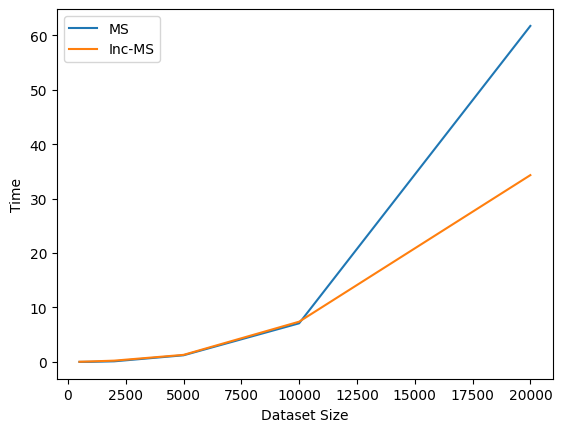

In [17]:
dfP = pd.DataFrame(result_dict)
dfP['dsize'] = [500, 1000, 2000, 5000, 10000, 19999]
dfP.set_index('dsize', inplace=True)
plt.figure(figsize=(10,5))
dfP.plot()
plt.xlabel("Dataset Size")
plt.ylabel("Time")
plt.show()

*nb: dari grafik di atas, terlihat bahwa IncMSPlot lebih efektif dalam menangani data yang besar, maka dari itu dapat mengatasi seperti masalah komputasi yang lebih baik.*

List percobaan dan hasilnya

1. Menggunakan data yang dinormalisasi dan tidak dinormalisasi : hasilnya sama saja dari segi grafik dan plot(maka dari itu rentang data tidak berpengaruh terhadap plot MS yang mana mengindikasikan msplot memang menanalsis berdasarkan fungsi dari datanya)

2. Melakukan skenario kombinasi kelompok kolom seperti pada cell 4 : didapatkan hasil yang berubah untuk plot ms dan deteksi outlier nya untuk MSPlot dengan scikit-fda. Namun untuk yang menggunakan IncMSPlot, hasilnya tetap stabil dengan data point outlier yang masih konsisten.

3. Percobaan simulasi di cell terakhir

**Kesimpulan**

Berdasarkan uji coba pada penelitian ini, didapatkan bahwa IncMSPlot memiliki keandalan dalam plot MS. Dengan hasil yang stabil, menjadikan IncMSPlot menjadi pilihan yang akan saya gunakan untuk mengembangkan program analitik visualisasi data streaming turbostat. Karena terbukti mampu mengatasi masalah komputasi yang berat, sehingga sangat cocok digunakan untuk analisis visualisasi data streaming yang dikenal dengan membutuhkan komputasi yang tinggi. Hal ini diharapkan nantinya program yang saya kembangkan dapat membantu ahli dalam menganalisis data hasil turbostat secara streaming.